# Exoplanet Detection

##### Shiva Gurunath 20BPS1028
##### Kuralamuthan B 20BPS1082

### Import Packages

In [102]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

### Importing the data

In [103]:
df = pd.read_csv('exoplanets_2018.csv')

print(df.shape)
df.head()

(9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [104]:
#Find the percent of null values in each feature
df.isna().mean()*100

kepid                  0.000000
kepoi_name             0.000000
kepler_name           75.334588
koi_disposition        0.000000
koi_pdisposition       0.000000
koi_score             15.788373
koi_fpflag_nt          0.000000
koi_fpflag_ss          0.000000
koi_fpflag_co          0.000000
koi_fpflag_ec          0.000000
koi_period             0.000000
koi_period_err1        4.746968
koi_period_err2        4.746968
koi_time0bk            0.000000
koi_time0bk_err1       4.746968
koi_time0bk_err2       4.746968
koi_impact             3.795483
koi_impact_err1        4.746968
koi_impact_err2        4.746968
koi_duration           0.000000
koi_duration_err1      4.746968
koi_duration_err2      4.746968
koi_depth              3.795483
koi_depth_err1         4.746968
koi_depth_err2         4.746968
koi_prad               3.795483
koi_prad_err1          3.795483
koi_prad_err2          3.795483
koi_teq                3.795483
koi_teq_err1         100.000000
koi_teq_err2         100.000000
koi_inso

In [105]:
df['ExoplanetCandidate'] = df['koi_pdisposition'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)

In [106]:
df['ExoplanetConfirmed'] = df['koi_disposition'].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

Missing values in the dataset


<AxesSubplot:>

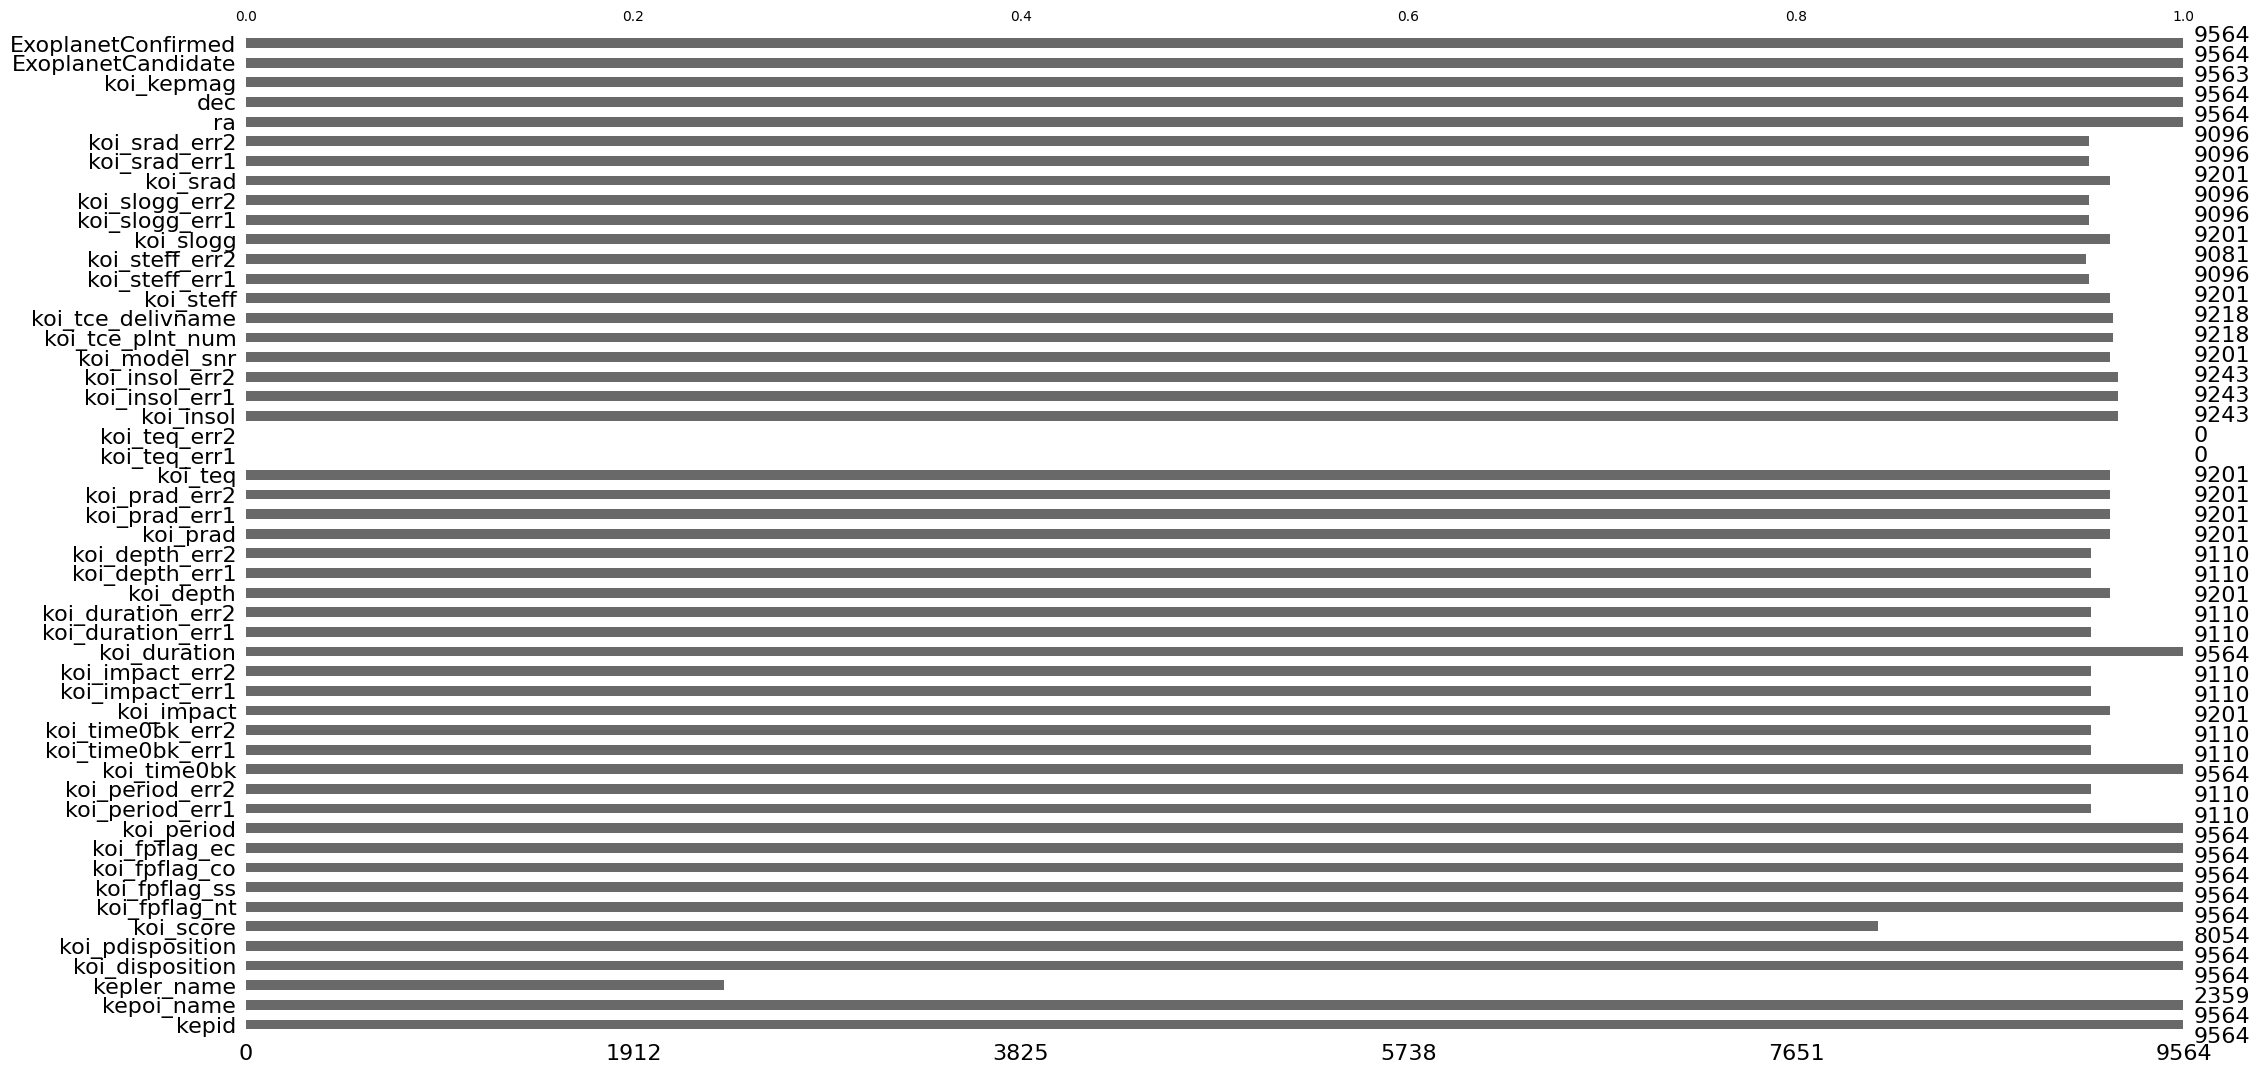

In [107]:
import missingno as msno
print("Missing values in the dataset")
msno.bar(df)

### Dropping Irrelevant features

In [108]:
df.drop(columns=['kepler_name','kepoi_name','koi_teq_err1',
                 'kepid','koi_disposition','koi_pdisposition',
                 'koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co',
                 'koi_fpflag_ec','koi_tce_delivname',
                 'koi_teq_err2'], inplace=True)

## Missing data

Missing values in the dataset


<AxesSubplot:>

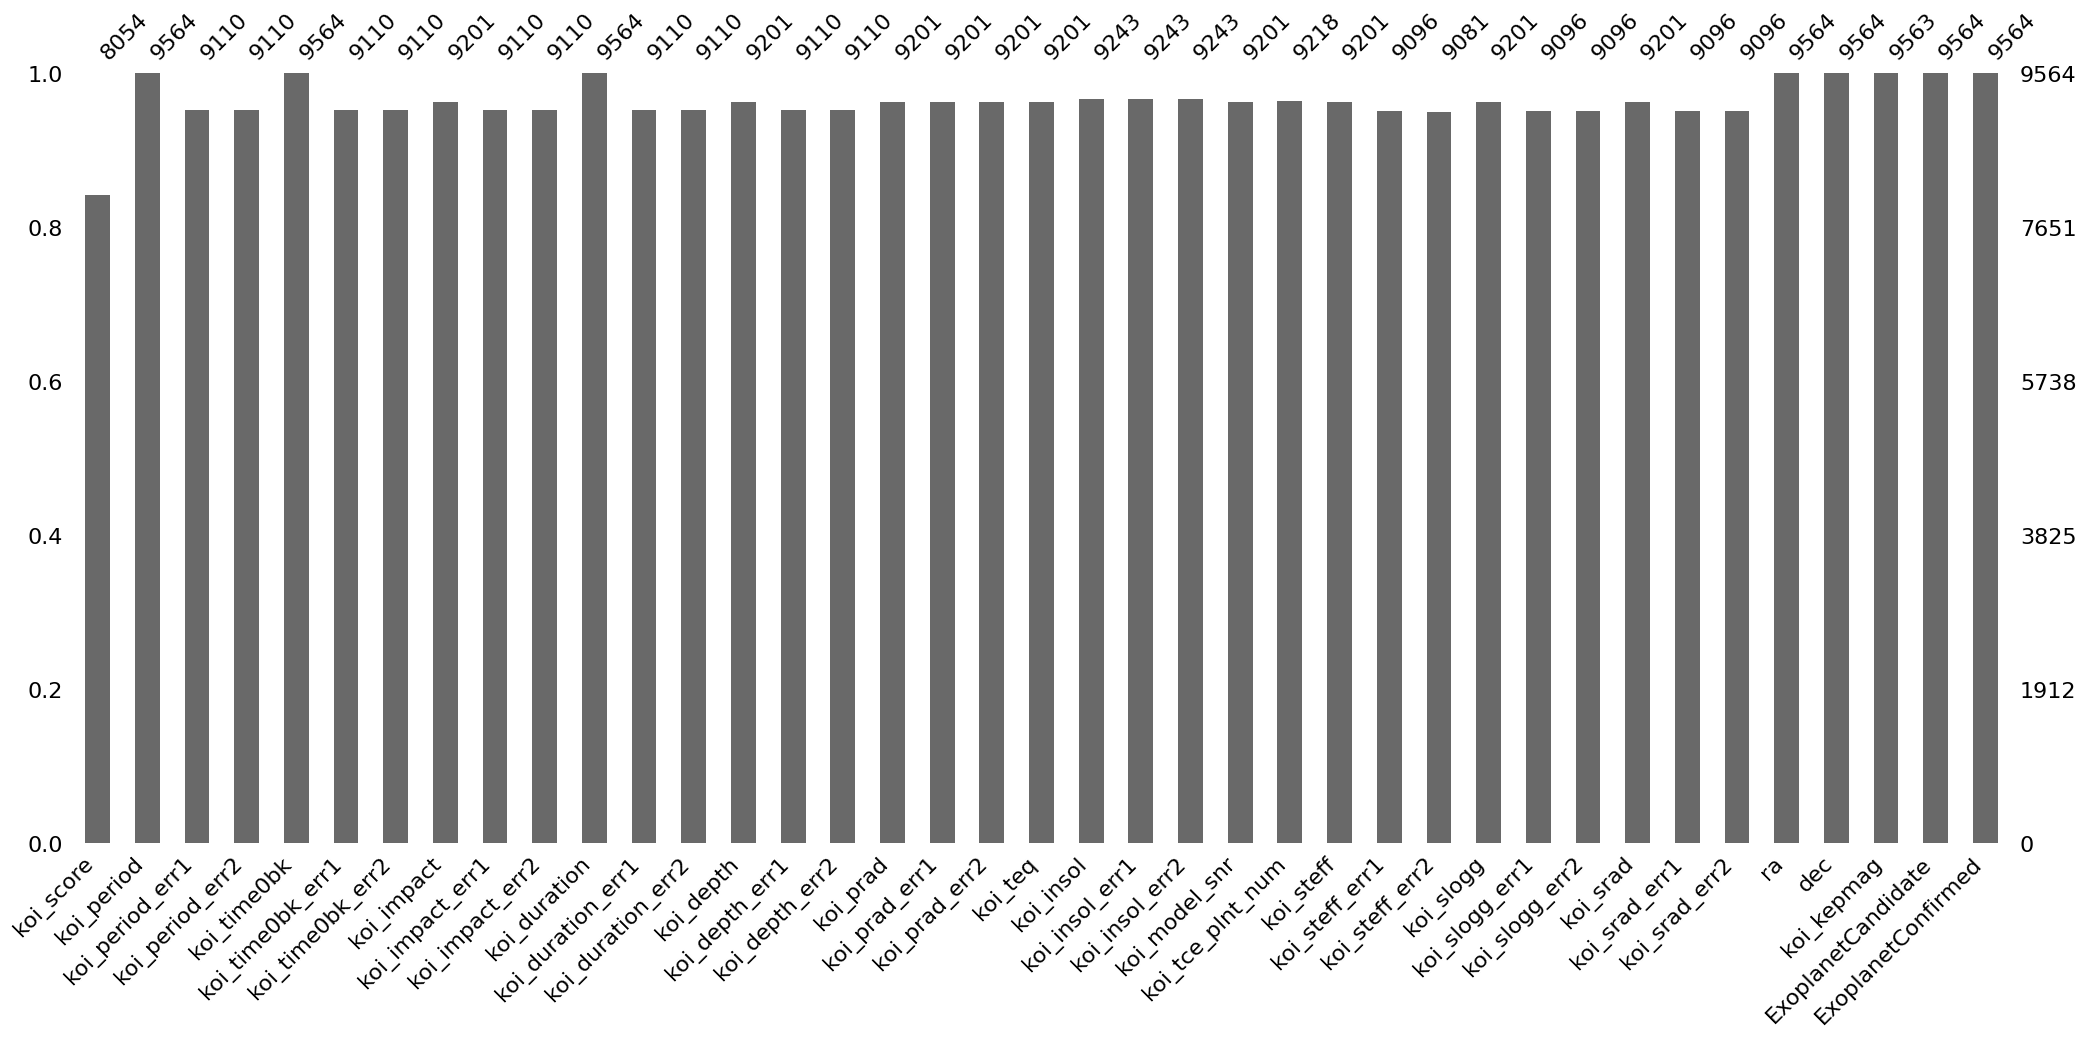

In [109]:
import missingno as msno
print("Missing values in the dataset")
msno.bar(df)

In [110]:
df.shape

(9564, 39)

### Important Functions

In [111]:
def evaluation(y_true, y_pred):
    
# Accuracy, Recall, F1 Score, and Precision metrics.
    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    
# Confusion Matrix
    print('\nConfusion Matrix:')
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

In [112]:
df.dropna(inplace=True)
features = df.drop(columns=['ExoplanetCandidate','ExoplanetConfirmed'])
target = df.ExoplanetCandidate

In [113]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1, test_size=.40)

## Model Pipeline

In [114]:
from sklearn.experimental import enable_iterative_imputer

In [115]:
## Preprocessing pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline

prep = make_pipeline(StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True))
# prep = make_pipeline(StandardScaler(), KNNImputer(n_neighbors=2, weights="uniform"))
# prep = make_pipeline(StandardScaler(), IterativeImputer(max_iter=10, random_state=0))
prep


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer(add_indicator=True))])

In [116]:
# Instantiate model
from sklearn.pipeline import make_pipeline

rf_pipeline = make_pipeline(prep, RandomForestClassifier(n_estimators=100, criterion='gini'))
rf_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('simpleimputer',
                                  SimpleImputer(add_indicator=True))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt_pipeline = make_pipeline(
    prep, GradientBoostingClassifier(n_estimators = 100, random_state=0, learning_rate = 1.0)
)
gbdt_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('simpleimputer',
                                  SimpleImputer(add_indicator=True))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            random_state=0))])

In [118]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Gradient Boosting", gbdt_pipeline)
]

stacking_clsf = StackingClassifier(estimators=estimators)
stacking_clsf.fit(X_train, y_train)

StackingClassifier(estimators=[('Random Forest',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=True))])),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier())])),
                               ('Gradient Boosting',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler()),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=True))])),
                                                ('gradientboostingclassifier',
                                                 GradientBoostingClassifier(learning_rate=1.0,
                                                                            random_state=0))]))])

Evaluation Metrics:
Accuracy: 0.9618834080717489
Recall: 0.9539312039312039
F1 Score: 0.9631007751937984
Precision: 0.9724483406386976

Confusion Matrix:


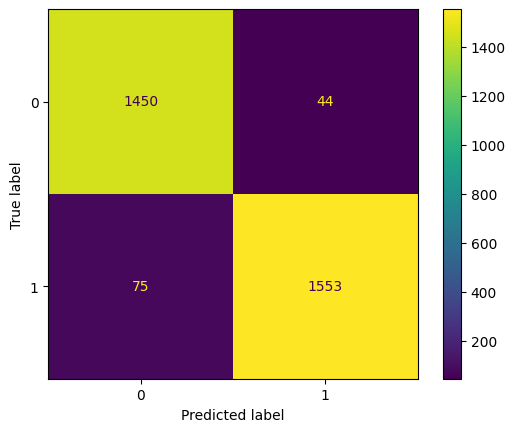

In [119]:
y_pred = stacking_clsf.predict(X_test)

evaluation(y_test, y_pred)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

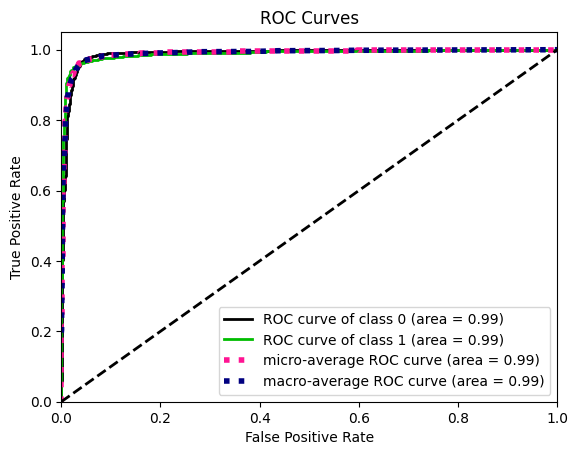

In [120]:
from scikitplot.metrics import plot_roc

y_pred_proba = stacking_clsf.predict_proba(X_test)
plot_roc(np.array(list(y_test)), y_pred_proba)


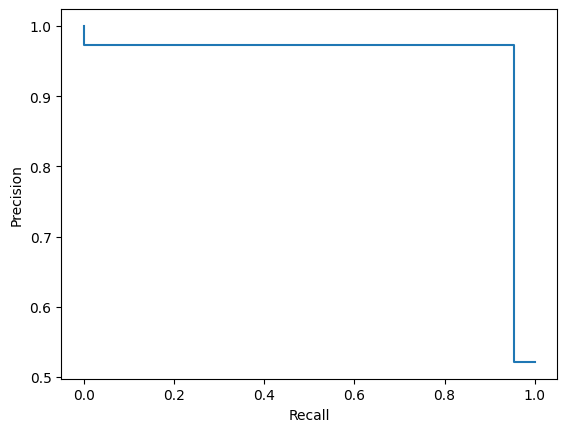

In [121]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

df.dropna(inplace=True)
features = df.drop(columns=['ExoplanetCandidate','ExoplanetConfirmed'])
target = df.ExoplanetCandidate
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1, test_size=.40)

lr_raw = LogisticRegression().fit(X_train, y_train)
dt_raw = DecisionTreeClassifier().fit(X_train, y_train)

lr_pred = lr_raw.predict(X_test)
stc_pred = stacking_clsf.predict(X_test)
dt_pred = dt_raw.predict(X_test)

lr_acc = metrics.accuracy_score(y_test, lr_pred)
stc_acc = metrics.accuracy_score(y_test, stc_pred)
dt_acc = metrics.accuracy_score(y_test, dt_pred)

/Users/shiva/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Calibration plots (Naive Bayes)')

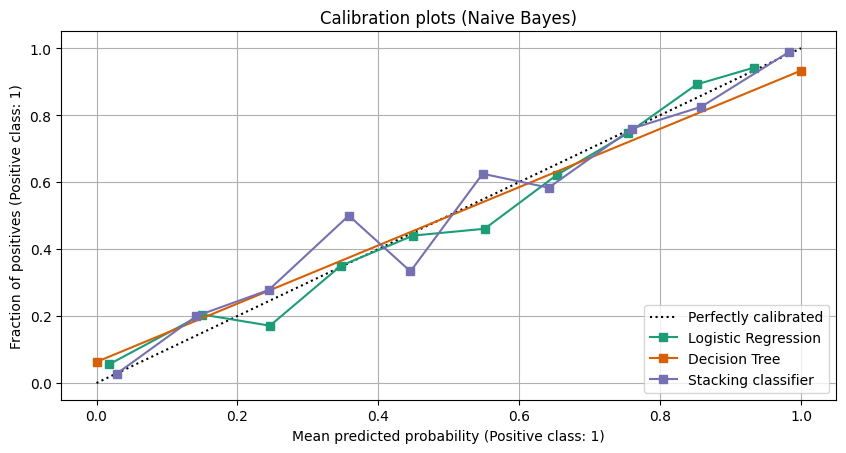

In [123]:
from matplotlib.gridspec import GridSpec

clf_list = [
    (lr_raw, "Logistic Regression"),
    (dt_raw, "Decision Tree"),
    (stacking_clsf, "Stacking classifier"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

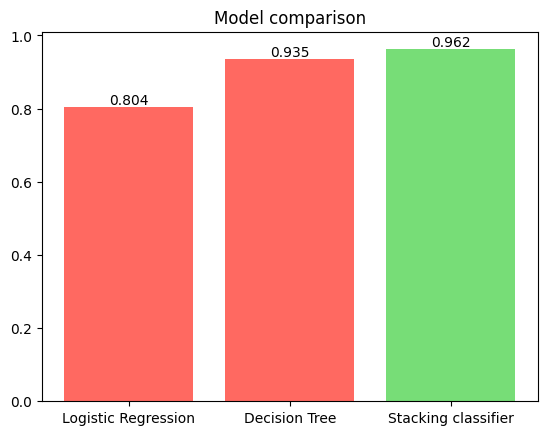

In [125]:
clsf_names = ["Logistic Regression", "Decision Tree", "Stacking classifier"]
clsf_acc = [round(lr_acc, 3), round(dt_acc, 3), round(stc_acc, 3)]
col = ['#ff6961', '#ff6961', '#77DD77']

bp = plt.bar(clsf_names, clsf_acc, color = col)
plt.title("Model comparison")
plt.bar_label(bp, labels = clsf_acc, label_type = "edge")
plt.show()